<a href="https://colab.research.google.com/github/Mathieu-Allaire/Classification-Binary/blob/main/Classification_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning to Predict who gets a Loan
##  Mathieu Allaire
Dawson College
Winter 2022
360-420-DW

## Setup

### Import Packages

In [ ]:
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt

###  TASK: Seperate the different features in to *categorical* and *continuous* 

In [ ]:
# path to data
url_path='https://raw.githubusercontent.com/jbrownlee/Datasets/master/adult-all.csv'

# names of all the features (columns)
names_list=[
    'age',
    'work-class',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'TARGET',
]

# TASK: Which are the `categorical` variables?
categorical_vars = [
  "work-class",
  "education",
  'marital-status',
  'occupation',
  'relationship',
  'race',
  'sex',
  'native-country'
]

# names of columns which should NOT be included in the model
vars_omit = ['fnlwgt','TARGET']

# everything else is a `continuous` variable
continuous_vars = [v for v in names_list if v not in categorical_vars and v not in vars_omit]

print("Continuous Variables: " + str(continuous_vars))
print("Categorical Variables: " + str(categorical_vars))
print("Target Variables: " + 'TARGET')


Continuous Variables: ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical Variables: ['work-class', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Target Variables: TARGET


### Load the data from UCI Machine Learning Repository

In [ ]:
df=pd.read_csv(
    url_path,
    names=names_list
    )
df.sample(5)

,age,work-class,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,TARGET
8025,60,Self-emp-not-inc,52900,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,42,United-States,>50K
22167,39,Private,341741,Preschool,1,Never-married,Other-service,Not-in-family,White,Female,0,0,12,United-States,<=50K
6095,31,Private,351187,HS-grad,9,Divorced,Other-service,Unmarried,White,Male,0,0,40,United-States,<=50K
45683,56,Self-emp-not-inc,52822,Bachelors,13,Divorced,Farming-fishing,Not-in-family,White,Male,0,0,30,United-States,<=50K
2698,50,Self-emp-not-inc,174752,HS-grad,9,Divorced,Farming-fishing,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [ ]:
df.groupby(["TARGET","sex"])["hours-per-week"].mean()

## Explore the data (`pandas`)

### TASKS

 - How many samples (people) in this dataset? 
 - Are there any missing values?
 - What is the distribution of people in each target class?
 - What is mean age?
 - What is the most frequent occupation?
 - What percentage of people have graduated from at least a bachelor's degree?
 - For people who make more than 50k/year, what is the average number of hours worked per week? How does that compare to those make less than 50k/year? 

## Visualize Data (`matplotlib`)

In [ ]:
import matplotlib.pyplot as plt 



fig, ax = plt.subplots(figsize=(10,8))

axes = df.boxplot(column="age", by='TARGET',ax=ax,)

In [ ]:
df["TARGET"].value_counts()

In [ ]:
# legend for coloring the different target classes
colors = {'<=50K':'red', '>50K':'green'}

# choose the continuous vars for scatter plot 
var1='age'
var2='hours-per-week'

fig, ax = plt.subplots()
grouped = df.groupby('TARGET')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x=var1, y=var2, label=key, color=colors[key],alpha=0.2)

plt.show()

In [ ]:
corr=df[continuous_vars].corr()

In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
# corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
df["race"].value_counts()

In [ ]:
import seaborn as sns

sns.set_theme(style="darkgrid")
# df = sns.load_dataset("penguins")
df.head()
sns.displot(
    df, x="age", col="race", row="sex",
    binwidth=10, height=3, facet_kws=dict(margin_titles=True),
)

## Machine learning model for binary classification (`sklearn`)

In [ ]:
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score

# X = df[categorical_vars+continuous_vars]
X = df[continuous_vars+categorical_vars]
y = df["TARGET"]

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, continuous_vars),
        ('cat', categorical_transformer, categorical_vars)])

model =  LogisticRegression(solver="liblinear")
# model =  DecisionTreeClassifier(max_depth=4)
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

In [ ]:
clf.fit(
    X=X,
    y=y
)
clf.predict(
    X
)

array(['<=50K', '<=50K', '<=50K', ..., '>50K', '<=50K', '>50K'],
      dtype=object)

In [ ]:
# https://github.com/scikit-learn/scikit-learn/issues/12525
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name


# feature_names = get_column_names_from_ColumnTransformer(preprocessor)
# df_feature_names=pd.DataFrame(
#     list
#     (
#         zip(
#             clf["classifier"].coef_[0],
#             feature_names)
#     ),
#     columns=["weight","feature"]
#     ).sort_values("weight")
# df_feature_names
# ax=df_feature_names.plot.bar(x="feature",y="weight",figsize=(20,10))

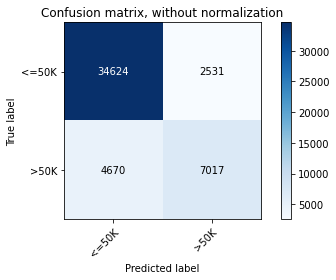

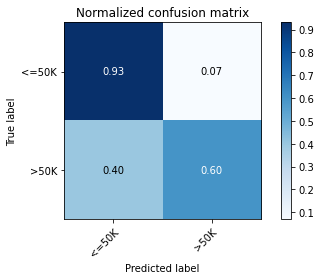

In [ ]:
###
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
###
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    # else:
        # print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

X = df[continuous_vars+categorical_vars]
y = df["TARGET"]
clf.fit(X,y)
y_pred=clf.predict(X)
y_test=y
np.set_printoptions(precision=2)
class_names = df.TARGET.value_counts().index

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

# plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=12
)

In [ ]:
X_train.shape,y_train.shape

((34189, 13), (34189,))

In [ ]:
X_test.shape,y_test.shape

((14653, 13), (14653,))

In [ ]:
clf.fit(
    X = X_train,
    y = y_train
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                               

In [ ]:
y_pred = clf.predict(
    X_test
)

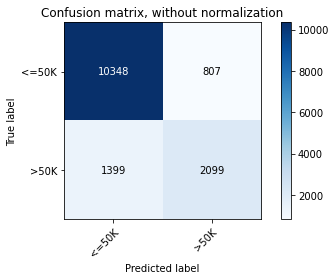

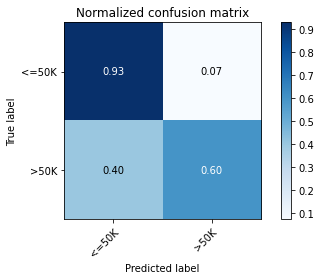

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')


In [ ]:
training_set_sizes = np.linspace(0.05,0.95,40)

results = []
for train_size in training_set_sizes:
  X_train,X_test,y_train,y_test = train_test_split(
      X,
      y,
      test_size=1.0-train_size,
  )
  clf.fit(
      X = X_train,
      y = y_train
  )
  y_pred = clf.predict(X_test)
  d = {
      "train_size":X_train.shape[0],
      "recall": f1_score(
          y_true=y_test,
          y_pred=y_pred,
          pos_label = ">50K"
          )
  }
  results.append(d)


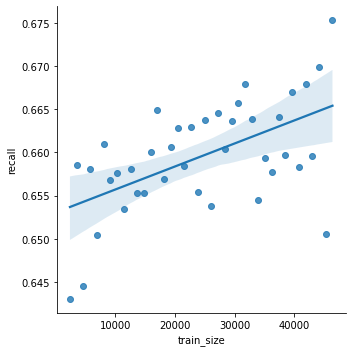

In [ ]:
df_results = pd.DataFrame(results)
# plt.scatter(
#     x=df_results["train_size"],
#     y=df_results["recall"]
# )
import seaborn as sns

sns.lmplot(
    data=df_results,
    x="train_size",
    y="recall"
)